<a href="https://colab.research.google.com/github/konstanzer/deep-learning/blob/master/mobilenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [61]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing import image
import tensorflow as tf
import tensorflow.keras.layers as tfl
from tensorflow.keras.applications import mobilenet_v2

from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation

In [101]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)
directory = "/content/drive/MyDrive/Colab Notebooks/data/alpacas/"

train_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='training',
                                             seed=42)
validation_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='validation',
                                             seed=42)
class_names = train_dataset.class_names

Found 327 files belonging to 2 classes.
Using 262 files for training.
Found 327 files belonging to 2 classes.
Using 65 files for validation.


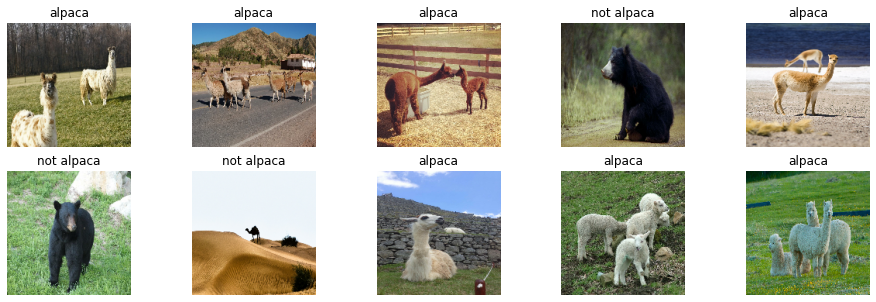

In [44]:
plt.figure(figsize=(16,5))
for images, labels in train_dataset.take(1):
  for i in range(10):
    ax = plt.subplot(2,5, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [45]:
#automatically set the number of elements to prefetch
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [46]:
def data_augmenter():
  '''Create a Sequential model composed of 2 layers
  Returns:
      tf.keras.Sequential
  '''
  data_augmentation = tf.keras.Sequential()
  data_augmentation.add(RandomFlip('horizontal'))
  data_augmentation.add(RandomRotation(0.2))
  
  return data_augmentation

In [47]:
def plot_accuracy_and_loss(history, history_fine, initial_epochs):
  
  acc = [0.] + history.history['accuracy'] + history_fine.history['accuracy']
  val_acc = [0.] + history.history['val_accuracy'] + history_fine.history['val_accuracy']
  loss = history.history['loss'] + history_fine.history['loss']
  val_loss = history.history['val_loss'] + history_fine.history['val_loss']

  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 1)
  plt.plot(acc, label='Training Accuracy')
  plt.plot(val_acc, label='Validation Accuracy')
  plt.ylim([0, 1])
  plt.plot([initial_epochs-1,initial_epochs-1],
            plt.ylim(), label='Start Fine Tuning')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(2, 1, 2)
  plt.plot(loss, label='Training Loss')
  plt.plot(val_loss, label='Validation Loss')
  plt.ylim([0, 1.0])
  plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.xlabel('epoch')

  plt.show()

In [73]:
def alpaca_model(image_shape=IMG_SIZE,
                 data_augmentation=data_augmenter(),
                 base_lr=.001,
                 initial_epochs=3, fine_tune_epochs=5,
                 fine_tune_at=120):
  ''' Define a tf.keras model for binary classification out of the MobileNetV2 model
  Arguments:
      image_shape -- Image width and height
      data_augmentation -- data augmentation function
  Returns:
      tf.keras.model
  '''
  input_shape = image_shape + (3,)
  base_model = mobilenet_v2.MobileNetV2(input_shape=input_shape,
                                        include_top=False, # <== Important!!
                                        weights='imagenet') # From imageNet
  # Freeze the base model by making it non trainable
  base_model.trainable =  False
  # create the input layer (Same as the imageNetv2 input size)
  inputs = tf.keras.Input(shape=input_shape) 
  # apply data augmentation to the inputs
  x = data_augmentation(inputs)
  # data preprocessing using the same weights the model was trained on
  x = mobilenet_v2.preprocess_input(x)
  # set training to False to avoid keeping track of statistics in the batch norm layer
  x = base_model(x, training=False) 
  # Add the new Binary classification layers
  # use global avg pooling to summarize the info in each channel
  x = tfl.GlobalAveragePooling2D()(x) 
  #include dropout with probability of 0.2 to avoid overfitting
  x = tfl.Dropout(.2)(x)
  # create a prediction layer with one neuron (as a classifier only needs one)
  prediction_layer = tfl.Dense(1)
  outputs = prediction_layer(x) 
  model = tf.keras.Model(inputs, outputs)

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_lr),
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=['accuracy'])
  
  history = model.fit(train_dataset,
                      validation_data=validation_dataset,
                      epochs=initial_epochs)
  
  base_model = model.layers[4]
  base_model.trainable = True
  print("\nNumber of layers in the base model: ", len(base_model.layers))
  print("Thawing layers after: ", fine_tune_at)
  for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False
  
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_lr/10),
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=['accuracy'])
  
  history_fine = model.fit(train_dataset,
                          epochs=initial_epochs+fine_tune_epochs,
                          initial_epoch=history.epoch[-1],
                          validation_data=validation_dataset)
  
  plot_accuracy_and_loss(history, history_fine, initial_epochs)

  return model

Epoch 1/3
9/9 [==============================] - 11s 758ms/step - loss: 0.9698 - accuracy: 0.4198 - val_loss: 0.8118 - val_accuracy: 0.4308
Epoch 2/3
9/9 [==============================] - 7s 639ms/step - loss: 0.7090 - accuracy: 0.5534 - val_loss: 0.5694 - val_accuracy: 0.6769
Epoch 3/3
9/9 [==============================] - 7s 640ms/step - loss: 0.6265 - accuracy: 0.6603 - val_loss: 0.4728 - val_accuracy: 0.7385

Number of layers in the base model:  154
Thawing layers after:  120
Epoch 3/8
9/9 [==============================] - 15s 994ms/step - loss: 0.6691 - accuracy: 0.6679 - val_loss: 0.3243 - val_accuracy: 0.8615
Epoch 4/8
9/9 [==============================] - 10s 890ms/step - loss: 0.3266 - accuracy: 0.8473 - val_loss: 0.3138 - val_accuracy: 0.7846
Epoch 5/8
9/9 [==============================] - 10s 885ms/step - loss: 0.2380 - accuracy: 0.8969 - val_loss: 0.1879 - val_accuracy: 0.9385
Epoch 6/8
9/9 [==============================] - 10s 878ms/step - loss: 0.2418 - accuracy: 0.

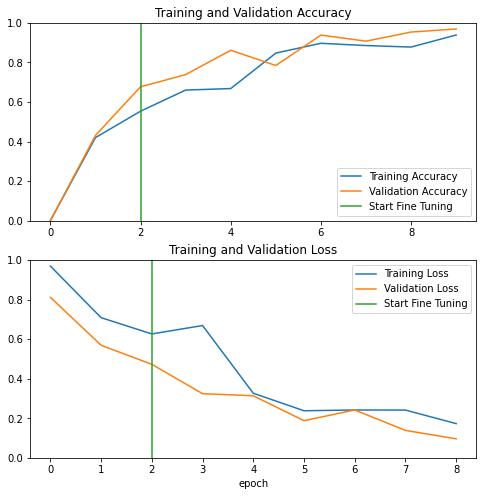

In [74]:
model = alpaca_model()

In [143]:
print(model.evaluate(validation_dataset))
print(class_names)
for _,l in validation_dataset: print(l)
model.predict(validation_dataset).T

3/3 [==============================] - 1s 247ms/step - loss: 0.0960 - accuracy: 0.9692
[0.09595008939504623, 0.9692307710647583]
['alpaca', 'not alpaca']
tf.Tensor([0 1 1 1 0 0 0 1 1 0 1 0 1 0 1 0 0 0 1 1 0 1 0 1 1 1 1 0 0 0 1 0], shape=(32,), dtype=int32)
tf.Tensor([1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 0 1 1 1 1 1 0 1 1], shape=(32,), dtype=int32)
tf.Tensor([0], shape=(1,), dtype=int32)


array([[ 0.75134045, -3.3574371 , -2.8240404 , -3.5063658 , -3.1148248 ,
         4.398463  , -3.0410252 ,  3.885204  , -3.9748273 ,  2.0805228 ,
         8.227243  , -1.6955789 ,  3.8104165 ,  3.6240776 , -0.21221225,
         3.3392193 ,  3.7544737 ,  5.749838  ,  7.5311866 ,  0.5187507 ,
         5.4318337 ,  4.6088433 , -2.9210715 , -4.4551215 , -1.5004709 ,
         3.9198017 ,  1.3714226 , -4.7404895 ,  6.2194304 ,  0.09599432,
         5.1922746 ,  0.2976503 ,  1.7208575 , -7.473899  ,  3.9133232 ,
         3.2602394 , -4.5596604 ,  5.1539764 ,  5.1731343 , -3.967258  ,
        -0.22104941,  3.151329  ,  7.7950506 ,  4.2289143 , -3.7162077 ,
        -6.0217166 ,  7.7804837 , -4.2801194 , -5.2325897 , -2.8142834 ,
         2.2676291 , -6.7896485 , -3.7623973 ,  2.3411543 ,  7.473312  ,
         4.71275   ,  7.1843934 ,  1.8015976 , -4.2165356 ,  0.56054294,
         3.4978611 ,  4.089149  ,  4.1836247 , -2.547713  ,  2.4040513 ]],
      dtype=float32)

[[3.9452493]]
[[3.9468727]]
[[3.8906622]]
[[3.8541195]]
[[3.7775433]]
[[4.1003404]]
[[3.8404548]]
[[3.868999]]
[[3.9808085]]
[[3.8610923]]


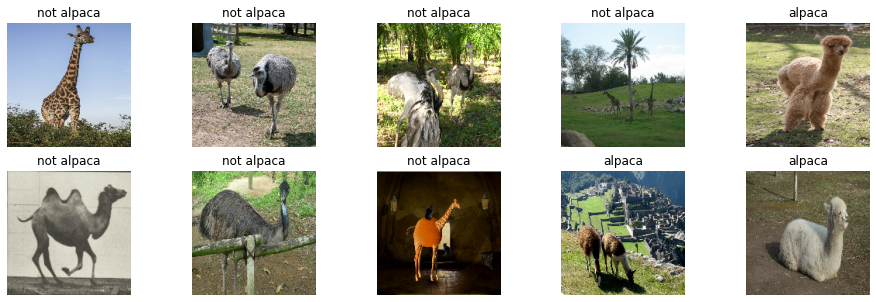

In [144]:
plt.figure(figsize=(16,5))
for images, labels in validation_dataset.take(1):
  for i in range(10):
    ax = plt.subplot(2,5, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    x = np.expand_dims(images[i], axis=0)
    x = mobilenet_v2.preprocess_input(x.copy())
    print(model(x).numpy())
    plt.axis("off")

Classes: ['alpaca', 'not alpaca']
Input image shape: (1, 160, 160, 3)


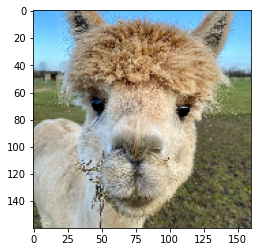

Class prediction vector =  [[3.8913283]]
Class:
Input image shape: (1, 160, 160, 3)


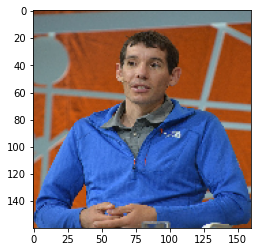

Class prediction vector =  [[3.86287]]
Class:
Input image shape: (1, 160, 160, 3)


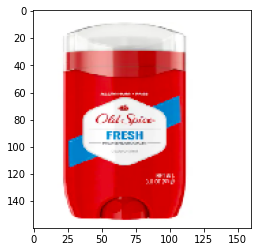

Class prediction vector =  [[4.580273]]
Class:


In [126]:
print(f'Classes: {class_names}')
img_path = "/content/drive/MyDrive/Colab Notebooks/my_images/"
for i in ['hello.jpg', 'honnold.jpg', 'os.jpg']:
  img = image.load_img(img_path+i, target_size=IMG_SIZE)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = mobilenet_v2.preprocess_input(x)
  print('Input image shape:', x.shape)
  plt.imshow(img)
  plt.show()
  prediction = model(x)
  print("Class prediction vector = ", prediction.numpy())
  print("Class:")

In [118]:
model.save(directory+"mobilenetv2.h5")

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [119]:
model2 = tf.keras.models.load_model(directory+"mobilenetv2.h5")

In [120]:
model2.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential_10 (Sequential)   (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv_6 (TFOpLambd (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract_6 (TFOpLamb (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_6 ( (None, 1280)              0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 1280)              0   